# Baseline K-Means Clustering

This notebook implements the baseline clustering model (K-Means) to see if natural fighting styles emerge from our engineered features.

## Steps
1. We select the Z-scored metrics (Volume, Grappling Intensity) and the Positional Ratios (Distance/Clinch/Ground).
2. Ensure all features are on the same scale (Z-score standardization).
3. **Elbow Method:** Determine the optimal number of clusters ($k$).
4. Analyze the centroids to understand what each cluster represents (e.g., "High Volume Striker" vs "Wrestler").
5. Project the clusters into 2D space using PCA.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load the finalized dataset
df = pd.read_csv('../data/processed/ufc_modeling_data_final.csv')

print(f"Loaded {len(df)} fighters.")
print(df.columns.tolist())

Loaded 1775 fighters.
['Fighter', 'Sig_Str_PM', 'Takedown_Att_PM', 'Sub_Att_PM', 'Distance_Ratio', 'Clinch_Ratio', 'Ground_Ratio', 'Control_Ratio', 'Total_Fights', 'Weight_Class', 'Sig_Str_PM_Z', 'Takedown_Att_PM_Z', 'Sub_Att_PM_Z', 'Control_Ratio_Z']


## 1. Feature Selection & Standardization
We use the Z-scored columns for volume/intensity metrics. We also include the Positional Ratios (Distance, Clinch, Ground), which define *where* the fight happens.

*Note: Even though ratios are 0-1, we standardize them to Z-scores so they have equal weight in the K-Means distance calculation compared to the other Z-scored metrics.*

In [2]:
# Features to Cluster On
features = [
    'Sig_Str_PM_Z',       # Striking Volume (Normalized)
    'Takedown_Att_PM_Z',  # Wrestling Aggression (Normalized)
    'Sub_Att_PM_Z',       # Grappling Threat (Normalized)
    'Control_Ratio_Z',    # Grappling Control (Normalized)
    'Distance_Ratio',     # Preference for Distance Fighting
    'Clinch_Ratio',       # Preference for Clinch
    'Ground_Ratio'        # Preference for Ground
]

# Extract matrix and drop NaNs to avoid errors
X = df[features].dropna()
print(f"Data shape for clustering: {X.shape}")

# Standardize the Ratio columns (Distance, Clinch, Ground) so they match the Z-scores
# The _Z columns are already standardized, but re-scaling everything ensures perfect alignment
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability (optional, but good for debugging)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=X.index)
print("Features standardized.")


Data shape for clustering: (1774, 7)
Features standardized.


## 2. The Elbow Method (Finding k)
We calculate the "Inertia" (Sum of Squared Distances to nearest cluster center) for $k=1$ to $10$.
Looking for the elbow where diminishing returns set in.

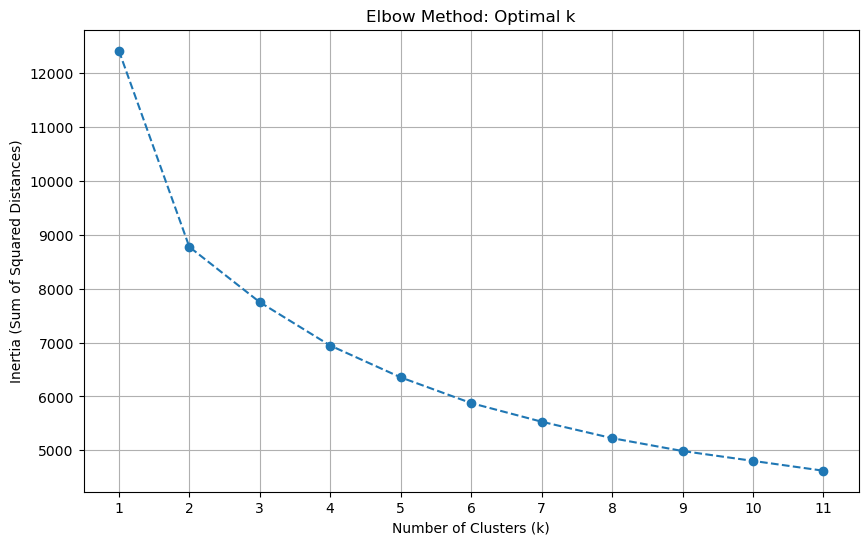

In [3]:
inertia = []
k_range = range(1, 12)

# Run K-Means for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## 3. Fit the Model (k=5)
Based on typical MMA archetypes (Striker, Wrestler, Grappler, Hybrid, Brawler), let's start with $k=5$.

In [7]:
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Attach cluster labels to original dataframe (using the index to match rows safely)
df_clustered = df.loc[X.index].copy()
df_clustered['Cluster'] = clusters

print(f"Assigned {k_optimal} clusters to {len(df_clustered)} fighters.")
print(df_clustered['Cluster'].value_counts())

Assigned 5 clusters to 1774 fighters.
Cluster
0    645
2    484
3    291
1    287
4     67
Name: count, dtype: int64


## 4. Cluster Interpretation (Centroids)
We visualize the average feature values for each cluster to understand what they represent.

*Note: Positive values mean "Above Average" for that trait. Negative means "Below Average".

AttributeError: 'numpy.int64' object has no attribute 'startswith'

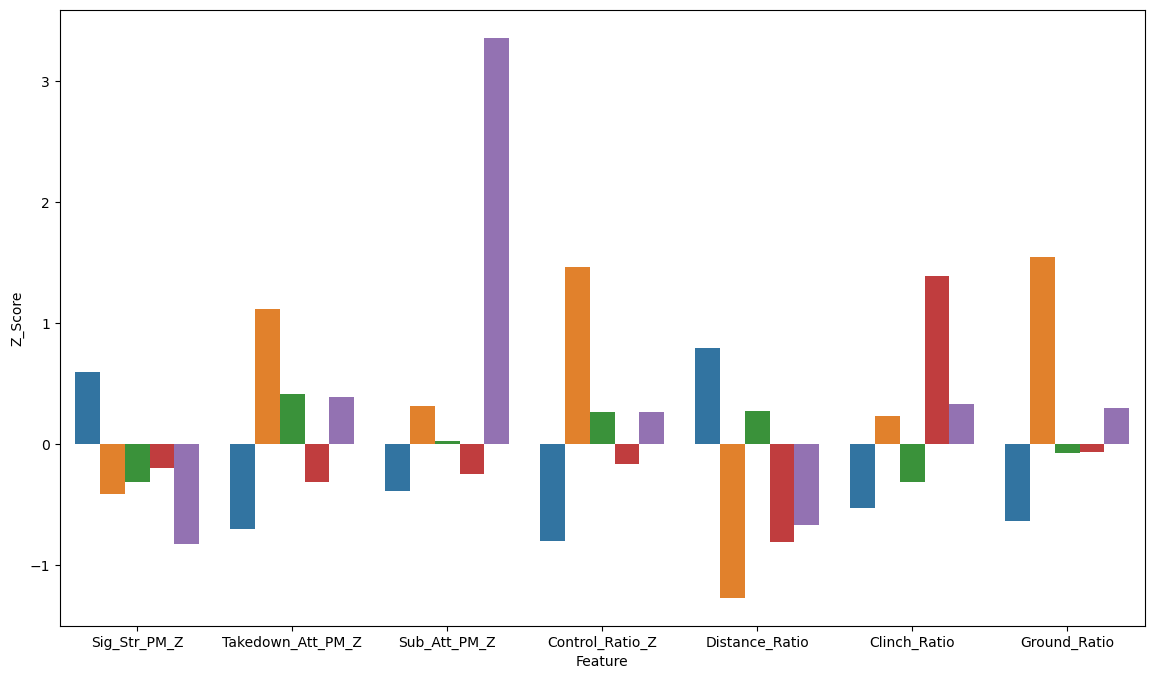

In [8]:
# Get centroids from the scaler's inverse transform or just groupby on the scaled dataframe
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=features)
centroids_scaled['Cluster'] = range(k_optimal)

# Melt for plotting
centroids_melt = centroids_scaled.melt(id_vars='Cluster', var_name='Feature', value_name='Z_Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Feature', y='Z_Score', hue='Cluster', data=centroids_melt, palette='tab10')
plt.title(f'Cluster Profiles (k={k_optimal}): Feature Z-Scores')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=1)
plt.legend(title='Cluster ID')
plt.grid(axis='y', alpha=0.3)
plt.show()


## 5. Visualizing w/PCA
We project the high-dimensional data (7 features) into 2 principal components to see the separation.

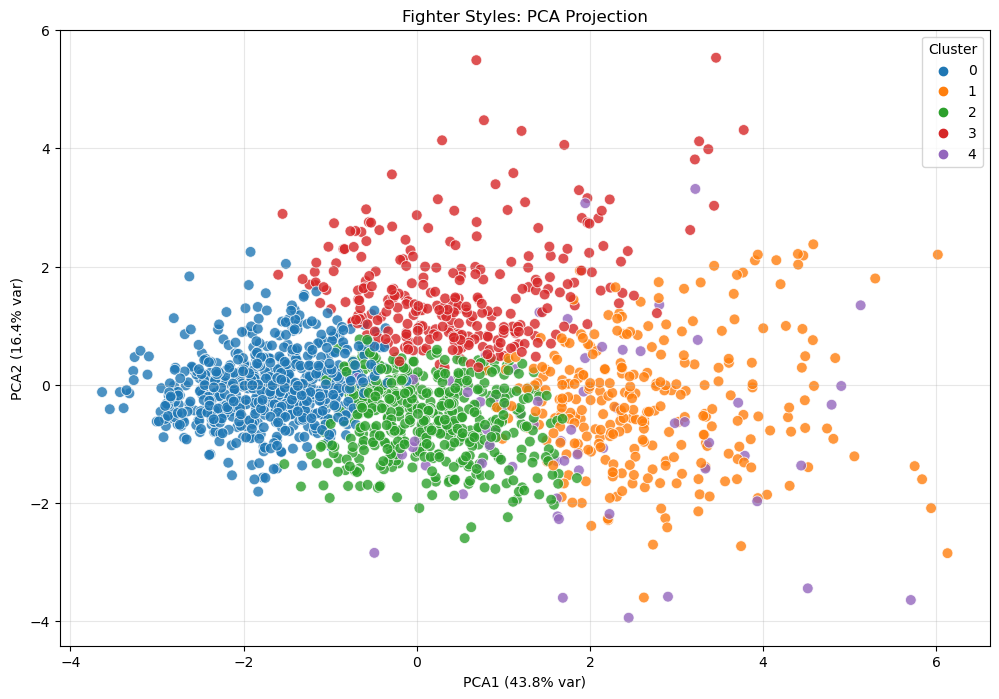

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_clustered['PCA1'] = X_pca[:, 0]
df_clustered['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    data=df_clustered, 
    palette='tab10', 
    s=60, 
    alpha=0.8
)
plt.title('Fighter Styles: PCA Projection')
plt.xlabel(f'PCA1 ({pca.explained_variance_ratio_[0]:.1%} var)')
plt.ylabel(f'PCA2 ({pca.explained_variance_ratio_[1]:.1%} var)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Cluster Examples
Sanity check.

In [9]:
for c in range(k_optimal):
    print(f"\n--- Cluster {c} Examples ---")
    print(df_clustered[df_clustered['Cluster'] == c]['Fighter'].head(10).values)

# sort this by number of fights


--- Cluster 0 Examples ---
['AJ Dobson' 'Abu Azaitar' 'Adam Milstead' 'Adam Wieczorek' 'Adrian Yanez'
 'Adriano Martins' 'Aiemann Zahabi' 'Akira Corassani' 'Al Iaquinta'
 'Alan Baudot']

--- Cluster 1 Examples ---
['Aaron Simpson' 'Ailin Perez' 'Aisling Daly' 'Alex Da Silva'
 'Alexandr Romanov' 'Alvin Robinson' 'Amanda Nunes' 'Andy Ogle'
 'Anthony Hamilton' 'Anthony Hernandez']

--- Cluster 2 Examples ---
['AJ Fletcher' 'Abdul Razak Alhassan' 'Abubakar Nurmagomedov'
 'Abus Magomedov' 'Adam Fugitt' 'Akbarh Arreola' 'Akihiro Gono'
 'Alan Belcher' 'Alan Patrick' 'Albert Duraev']

--- Cluster 3 Examples ---
['Aaron Phillips' 'Aaron Riley' 'Aaron Rosa' 'Abel Trujillo'
 'Aleksa Camur' 'Aleksandra Albu' 'Alessio Sakara' 'Alex Chambers'
 'Alex Karalexis' 'Alex Reyes']

--- Cluster 4 Examples ---
['Bo Nickal' 'Charles McCarthy' 'Charles Oliveira' 'Chris Lytle'
 'Christian Wellisch' 'Clayton Carpenter' 'Cody McKenzie' 'Dan Miller'
 'Daniel Pineda' 'Daniel Roberts']


In [10]:
# Save Results
df_clustered.to_csv('../data/processed/ufc_clusters_baseline.csv', index=False)
print("Saved clustered data to ../data/processed/ufc_clusters_baseline.csv")

Saved clustered data to ../data/processed/ufc_clusters_baseline.csv
